In [11]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

In [2]:
data_activity = pd.read_csv('data/_train_sem09__1_.zip')

In [3]:
data_activity.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data_activity.shape

(3751, 1777)

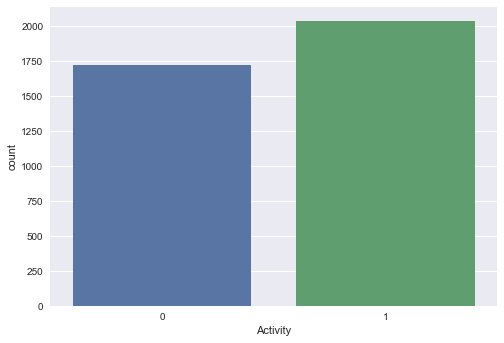

In [5]:
# Смотрим на сбалансированность классов:
sns.countplot(data=data_activity, x='Activity');
# классы не сильно, но несбалансированы

In [6]:
# Создаем матрицу наблюдений X и вектор ответов y
X = data_activity.drop(['Activity'], axis=1)
y = data_activity['Activity']

In [7]:
# Разделяем выборку на тренировочную и тестовую в соотношении 80/20. 
# Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

In [8]:
from locale import normalize


display(y_train.value_counts(normalize = True))
y_test.value_counts(normalize = True)
# Тренировоная и тестовая выборка сбалансированы 

1    0.542333
0    0.457667
Name: Activity, dtype: float64

1    0.541944
0    0.458056
Name: Activity, dtype: float64

In [59]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
print("f1_score на train: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на train: 0.89
f1_score на тестовом наборе: 0.78


In [10]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
# Видно, что модель имеет признаки переобучения, однако, получены неплохие score на test

Train: 1.00
Test: 0.80


### <center> **GridSearchCV**

### LogisticRegression

In [13]:
# задаем диапазон параметров для логистической регрессии
param_grid = {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.5, 1]}
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time 
grid_search.fit(X_train, y_train) 
y_train_pred = grid_search.predict(X_train)
print('f1_score на трейн наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


In [20]:
y_train_pred = grid_search.predict(X_train)
print('f1_score на трейн наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

f1_score на трейн наборе: 0.82
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


### RandomForestClassifier

In [23]:

# Оптимизируем параметры RandomForestClassifier с кросс-валидацией на пяти фолдах

param_grid = {'n_estimators': [100, 300] , # количество деревьев
              'min_samples_leaf': [5,7], # минимальное количество объектов в листе
               'max_depth': [15,35]}

grid_search = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(
        random_state=42, #генератор случайных чисел
        # max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time 
grid_search.fit(X_train, y_train) 
y_train_pred = grid_search.predict(X_train)
print('f1_score на трейн наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
f1_score на трейн наборе: 0.94
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 300}


### <center> **RandomizedSearchCV**

### LogisticRegression

In [28]:
# задаем распределение параметров для поиска по методу RandomizedSearchCV
param_distributions = {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 1]}
            
random_search_logreg = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1,
    return_train_score=True
)  
%time 
random_search_logreg.fit(X_train, y_train) 
y_train_pred = random_search_logreg.predict(X_train)
print('f1_score на трейн наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_logreg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_logreg.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


f1_score на трейн наборе: 0.82
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}


### RandomForestClassifier

In [33]:
# задаем распределение параметров для поиска по методу RandomizedSearchCV
param_distributions = {'min_samples_leaf': [3,5,7],
              'max_depth': [15,40],
              'criterion':['entropy','gini'],
              'n_estimators':[100,300]
              }
            
random_search_randomforest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1,
    return_train_score=True
)  


CPU times: total: 0 ns
Wall time: 0 ns
f1_score на трейн наборе: 0.97
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 300, 'min_samples_leaf': 3, 'max_depth': 15, 'criterion': 'gini'}


In [34]:
%time 
random_search_randomforest.fit(X_train, y_train) 
y_train_pred = random_search_randomforest.predict(X_train)
print('f1_score на трейн наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_randomforest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_randomforest.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
f1_score на трейн наборе: 0.97
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 300, 'min_samples_leaf': 3, 'max_depth': 15, 'criterion': 'gini'}


### <center> Hyperopt

In [35]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


### LogisticRegression

In [ ]:
#param_distributions = {'penalty': ['l2', 'none'] , # тип регуляризации
 #             'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
#               'C': list(np.linspace(0.01, 1, 10, dtype=float))}

# зададим пространство поиска гиперпараметров
space={'penalty': hp.choice('penalty', ['l2', 'none']),
       'solver' : hp.choice('solver', ['lbfgs', 'sag']),
       'C': hp.quniform('C', 0.01,1,0.1)
      }

In [36]:
# задаем возможные значения параметров логистической регрессии
list_solver = ['liblinear', 'saga']
list_penalty = ['l2','l1']

search_space = {
                'solver':  hp.choice(label='solver', options=list_solver),
                'penalty' : hp.choice(label='penalty', 
                          options=list_penalty),
                'C' : hp.uniform(label='C', 
                        low=0.01, 
                        high=1)
                }

In [37]:
# зафксируем random_state
random_state = 42
def hyperopt_logreg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
              'C': params['C']
              }
    # print(params['penalty'])
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=1000)

    # обучаем модель
    model.fit(X, y)
    # score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [38]:
# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_logreg, # наша функция 
          space=search_space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
 30%|███       | 6/20 [01:42<05:00, 21.49s/trial, best loss: -0.7920651360713664]

C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 55%|█████▌    | 11/20 [03:57<02:42, 18.00s/trial, best loss: -0.7920651360713664]

C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 16/20 [06:54<01:39, 24.99s/trial, best loss: -0.7920651360713664]

C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 20/20 [09:43<00:00, 29.20s/trial, best loss: -0.7920651360713664]
Наилучшие значения гиперпараметров {'C': 0.16941386753130935, 'penalty': 1, 'solver': 1}


In [40]:
# Лог. рег. с наилучшими параметрами
model = linear_model.LogisticRegression(
    random_state=random_state, 
    solver=list_solver[best['solver']],
    penalty=list_penalty[best['penalty']],
    C=best['C'], 
    max_iter=1000
    )
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.82
f1_score на тестовом наборе: 0.78


In [42]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 50),
       'max_depth' : hp.quniform('max_depth', 15, 21, 2),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 8, 3)
      }

### RandomForestClassifier

In [43]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    # score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [45]:
# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 20/20 [01:13<00:00,  3.70s/trial, best loss: -0.8160314454584471]
Наилучшие значения гиперпараметров {'max_depth': 16.0, 'min_samples_leaf': 3.0, 'n_estimators': 150.0}


In [46]:
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.97
f1_score на тестовом наборе: 0.80


## <center> Optuna

### LogisticRegression

In [47]:
def optuna_log_reg(trial):
  # задаем пространства поиска гиперпараметров
  solver = trial.suggest_categorical('solver', list_solver)
  penalty = trial.suggest_categorical('penalty', list_penalty)
  C = trial.suggest_float('C', 0.01, 1)

  # создаем модель
  model = linear_model.LogisticRegression(solver=solver, penalty=penalty, C=C, random_state=random_state, max_iter=1000)
  
  
  # обучаем модель
  model.fit(X_train, y_train)
  # score = metrics.f1_score(y_train, model.predict(X_train))
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  return score

In [48]:
%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_log_reg, n_trials=20)

[I 2022-10-05 16:06:24,101] A new study created in memory with name: LogisticRegression
[I 2022-10-05 16:06:25,531] Trial 0 finished with value: 0.7851563321794984 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.11860041460815697}. Best is trial 0 with value: 0.7851563321794984.
[I 2022-10-05 16:06:27,186] Trial 1 finished with value: 0.7764956573903922 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.7589646597201847}. Best is trial 0 with value: 0.7851563321794984.
[I 2022-10-05 16:07:17,308] Trial 2 finished with value: 0.7742623933483543 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.9544623905598386}. Best is trial 0 with value: 0.7851563321794984.
[I 2022-10-05 16:07:18,677] Trial 3 finished with value: 0.7767862489675463 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.3175875806695267}. Best is trial 0 with value: 0.7851563321794984.
[I 2022-10-05 16:07:20,371] Trial 4 finished with value: 0.7762707728445116 and paramete

CPU times: total: 4min 19s
Wall time: 9min 20s


In [49]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'solver': 'saga', 'penalty': 'l1', 'C': 0.14683910222371127}
f1_score на обучающем наборе: 0.79


In [51]:
# задаем наилучшие парметры по Optuna для лог. регрессии и оцениваем score для train и test 
model = linear_model.LogisticRegression(
    random_state=random_state, 
    solver=study.best_params['solver'],
    penalty=study.best_params['penalty'],
    C=study.best_params['C']
    )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print(f'f1_score на обучающем наборе: {metrics.f1_score(y_train, y_train_pred)}')
print(f'f1_score на обучающем наборе при кроссвалидации: {cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()}')

y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred)}')

C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


f1_score на обучающем наборе: 0.8161434977578477
f1_score на обучающем наборе при кроссвалидации: 0.790529204355831
f1_score на тестовом наборе: 0.7706855791962176


### RandomForest

In [52]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 310, 50)
  max_depth = trial.suggest_int('max_depth', 15, 46, 15)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 8, 2)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  # score = metrics.f1_score(y_train, model.predict(X_train))
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  return score

In [53]:
%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-10-05 18:23:06,389] A new study created in memory with name: RandomForestClassifier


CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [100, 310] and step=50, but the range is not divisible by `step`. It will be replaced by [100, 300].
  warnings.warn(
C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [15, 46] and step=15, but the range is not divisible by `step`. It will be replaced by [15, 45].
  warnings.warn(
C:\Users\Arwielao\AppData\Roaming\Python\Python310\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [3, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 7].
  warnings.warn(
[I 2022-10-05 18:23:15,913] Trial 0 finished with value: 0.8079193768629048 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8079193768629048.
C:\Users\Arwielao\AppData\Roaming\Py

In [54]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.82


In [57]:
# Создаем модель с наилучшими параметрами, определенными методом Optuna 
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    min_samples_leaf=study.best_params['min_samples_leaf']
    )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print(f'f1_score на обучающем наборе: {metrics.f1_score(y_train, y_train_pred)}')
print(f'f1_score на обучающем наборе при кроссвалидации: {cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()}')
y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred)}')

f1_score на обучающем наборе: 0.9637967751749316
f1_score на обучающем наборе при кроссвалидации: 0.8154509271841853
f1_score на тестовом наборе: 0.8009708737864076


### <center> ВЫВОДЫ
1. Для поиска оптимальных значений параметров модели применялись четыре метода оптимизации: GRIDSEARCHCV, RANDOMIZEDSEARCHCV, HYPEROPT (алгоритм Tree-Structured Parzen Estimators) и Optuna.
2. Для сокращения времени оптимизации были уменьшены диапазоны и количество значений категориальных парамтеров (например, метод поиска максимума функции правдоподобия в логистической регрессии)
3. На всех типах оптимизации для RandomForest наблюдается более высокие score (f1-мера), чем для логистической регрессии
4. Классический метод GridSearchCV показал наибольшее время работы даже при относительно небольших диапазонах параметров модели